Programmable state machines in rust
--------------------------------------------------------
- Author: [Timothy Hobbs](https://timothy.hobbs.cz)
- License: [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/)
- Written: 12.2019
- Send PRs to: [github](https://github.com/timthelion/rust-jupyter)

[project homepage](https://github.com/timthelion/rust-pfsm) [ipynb](./pfsm.ipynb)

Rust has several finite state machine packages. However, all of them are meant for state machines who's state network is known at compile time. I needed a programmable state machine, so I turned to the petgraph library for help.

I started by creating a struct:

In [2]:
:sccache 1

sccache: true


In [3]:
:dep petgraph-evcxr = {path="./petgraph-evcxr"}
:dep petgraph = {path="./petgraph"}

In [4]:
extern crate petgraph;
use petgraph::*;
use crate::petgraph::visit::*;
use petgraph::data::*;
use petgraph::graph::*;
use petgraph_evcxr::draw_graph_with_attr_getters;

struct StateMachine<G>
where
    G: GraphBase,
{
    state_network: G,
    state: <G as GraphBase>::NodeId,
}

This struct stores the FSM network as well as the current state.

In [5]:
impl<G> StateMachine<G>
 where
    G: IntoNodeReferences + IntoEdgeReferences + IntoEdges + Data,
    G: NodeIndexable + GraphProp + DataMap + GraphBase,
    <G as Data>::NodeWeight: Eq + Copy,
    <G as Data>::EdgeWeight: Eq + Copy,
{
    pub fn next(&mut self, input: <G as Data>::EdgeWeight) -> Option<<G as Data>::NodeWeight> {
        for edge in self.state_network.edges(self.state) {
            if *edge.weight() == input {
                self.state = edge.target();
                return match self.state_network.node_weight(self.state) {
                    Option::Some(weight) => Some(*weight),
                    Option::None => Option::None,
                }
            }
        }
        return Option::None
    }
    
    pub fn new(
        network: G,
        start: <G as Data>::NodeWeight
    )
        -> Option<StateMachine<G>> {
        for nr in network.node_references() {
            if *(network.node_weight(nr.id())).unwrap() == start {
                return Option::Some(StateMachine{
                    state_network: network,
                    state: nr.id(),
                })
            }
        }
        return Option::None
    }
}

In [6]:
use petgraph::dot::Dot;

impl<G> StateMachine<G>
 where
    G: IntoNodeReferences + IntoEdgeReferences + NodeIndexable + GraphProp,
    <G as petgraph::visit::Data>::NodeWeight: std::fmt::Display,
    <G as petgraph::visit::Data>::EdgeWeight: std::fmt::Display,
{
    pub fn draw_evcxr(&self) {
        draw_graph_with_attr_getters(
            self.state_network,
            &[],
            &|_, _| "".to_string(),
            &|_, nr| (if nr.id() == self.state { "shape = circle style = filled fillcolor = red" } else { "shape = circle" }).to_string(),
        );
    }
}

The logic is encoded in the `next` method, which takes an `Input` token and returns the next `State`. The input tokens and states can be anything.

In [9]:
let mut sn : Graph<&str, u32, petgraph::Directed> = Graph::new();
let sn_item1 = sn.add_node("a");
let sn_item2 = sn.add_node("b");
let sn_item3 = sn.add_node("c");
let sn_item4 = sn.add_node("d");
let sn_item5 = sn.add_node("e");
sn.add_edge(sn_item1, sn_item2, 1);
sn.add_edge(sn_item1, sn_item3, 2);
sn.add_edge(sn_item2, sn_item4, 1);
sn.add_edge(sn_item2, sn_item5, 2);
sn.add_edge(sn_item5, sn_item1, 2);
sn.add_edge(sn_item5, sn_item3, 1);

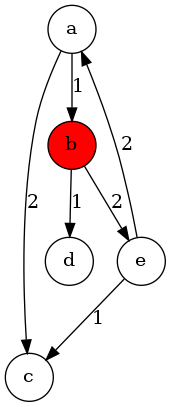

In [22]:
{
    let mut sm = StateMachine::new(&sn, "a").unwrap();
    sm.next(1);
    sm.next(2);
    sm.next(2);
    sm.draw_evcxr();
    sm.next(1);
    sm.draw_evcxr();
}